In [87]:
import os
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import networkx as nx

# GNN and LSTM
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers
from keras import ops

# XGBOOST
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

This notebook aims to compare a traditional and novel apporach for predicting the speed of of a road segment using historical speed time-series. Two methods are being pursued:

1- A traditional approach for predicting the speed for individual road segment using a machine learning forecaster, in this case XGBOOST.

2- A novel approach proposed by Arash Khodadadi and based on a research paper by Bing et. al that considers the relation between the road segments rather than just looking at one segment at a time. The model is based on a Graph Neural Netwrok (GNN) and a LSTM model.

More to read on 

https://github.com/VeritasYin/STGCN_IJCAI-18

https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

## Loading the data

The data is a real-world traffic speed dataset named PeMSD7 that was further processed and clean by Yu et al.

"The data consists of two files:

PeMSD7_W_228.csv contains the distances between 228 stations across the District 7 of California.

PeMSD7_V_228.csv contains traffic speed collected for those stations in the weekdays of May and June of 2012."

For more infromation refer to 

https://github.com/VeritasYin/STGCN_IJCAI-18

https://arxiv.org/abs/1709.04875

In summary, the speed data is from May 1, 2012 12:00 AM to June 29, 2012 11:55 PM only on weekdays and aggregated at 5 minute intervals, which is a total of 12672 data points. The speed data is recorded for 228 road segments, meaning an array of 12672 speed values for each of the 228 road segments. 

The route distance data is a squared matrix of 228 road segment, where route (i,j) is the distance between the tow road segments i and j. 

In [88]:
route_distances = pd.read_csv(
    os.path.join("PeMSD7_W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(
    os.path.join("PeMSD7_V_228.csv"), header=None
).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


Quoting Arash Khodadadi's work in https://keras.io/examples/timeseries/timeseries_traffic_forecasting/:

"To reduce the problem size and make the training faster, we will only work with a sample of 26 roads out of the 228 roads in the dataset. We have chosen the roads by starting from road 0, choosing the 5 closest roads to it, and continuing this process until we get 25 roads. You can choose any other subset of the roads. We chose the roads in this way to increase the likelihood of having roads with correlated speed timeseries. sample_routes contains the IDs of the selected roads."

In [89]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


Plotting the route 0 and route 8 speed time-series data as an example:

Text(0, 0.5, 'Speed')

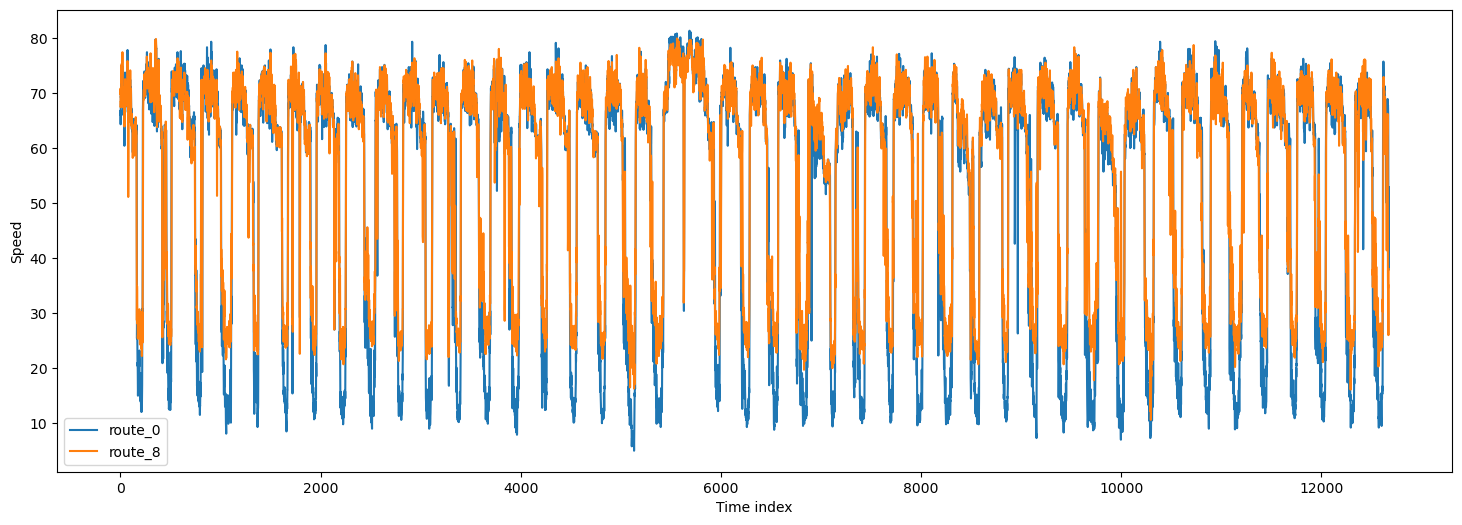

In [117]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [1,5]])
plt.legend(["route_0", "route_8"])
plt.xlabel("Time index")
plt.ylabel("Speed")

Plotting the correlation coefficients between the road segments that indicates the closeness of road segments and how related they are to each other. The yellow color indiciates high correlation and the dark blue color indicates a low correlation between the roads meaning they are far from each other. 

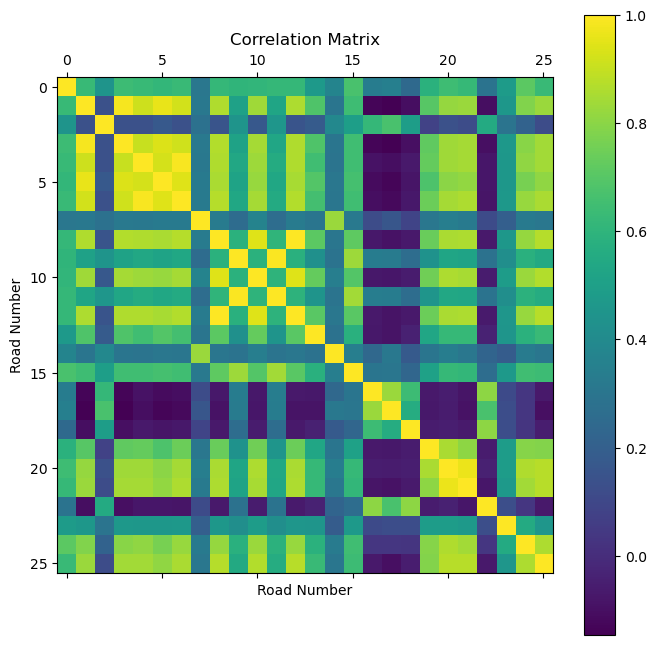

In [91]:
# Assuming speeds_array is your data
correlation_matrix = np.corrcoef(speeds_array.T)  

plt.figure(figsize=(8, 8))
cax = plt.matshow(correlation_matrix, fignum=1)  
plt.colorbar(cax) 
plt.xlabel("Road Number")
plt.ylabel("Road Number")
plt.title("Correlation Matrix")
plt.show()

## GNN and LSTM

The below code blocks in the GNN and LSTM section are the exact repliacation of work by Arash Khodadadi in https://keras.io/examples/timeseries/timeseries_traffic_forecasting/, except the visualization parts where netwrokxx is used to depict the adjacenecy network, matplotlib is used to plot the training and validation losses and the testing results.

You may refer to the above link for further details. In summary, the following steps are being taken:

Data Splitting and Normalization:

The speed values array is split into training, validation, and test sets.
These data subsets are normalized to ensure the model receives standardized input.

Creating TensorFlow Datasets:

The forecasting problem is defined as predicting future road speeds based on a sequence of past observations.
The create_tf_dataset() function uses keras.utils.timeseries_dataset_from_array to prepare tf.data.Dataset objects.
Depending on the multi_horizon parameter, the target tensor's shape is adjusted to either include multiple future steps (True) or a single future step (False).

Input Feature Handling:

Each batch's input tensor has the shape (batch_size, input_sequence_length, num_routes, 1), indicating the use of a single feature (speed) per road.
This setup allows for the potential inclusion of additional time series data per road in future model enhancements.

Graph Representation of Roads:

Road segments are represented as nodes in a graph, and edges are defined based on proximity (distance less than a threshold).
This graph structure is used to inform the model about the relationships between different road segments.

Network Architecture:

The model includes a graph convolution layer and an LSTM layer.
Graph Convolution Layer: This layer processes node features and aggregates information from neighboring nodes, enhancing each node's data with context from its connections.
LSTM Layer: Sequential data is processed using LSTM units, integrating temporal dynamics into the node features prepared by the graph convolution layer.

Making Forecasts on Test Set:

The trained model is used to predict future speeds on the test set.
Model performance is evaluated using the Mean Absolute Error (MAE), and results are compared to naive forecasts (last observed values).

In [92]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


In [93]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [94]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [95]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 150


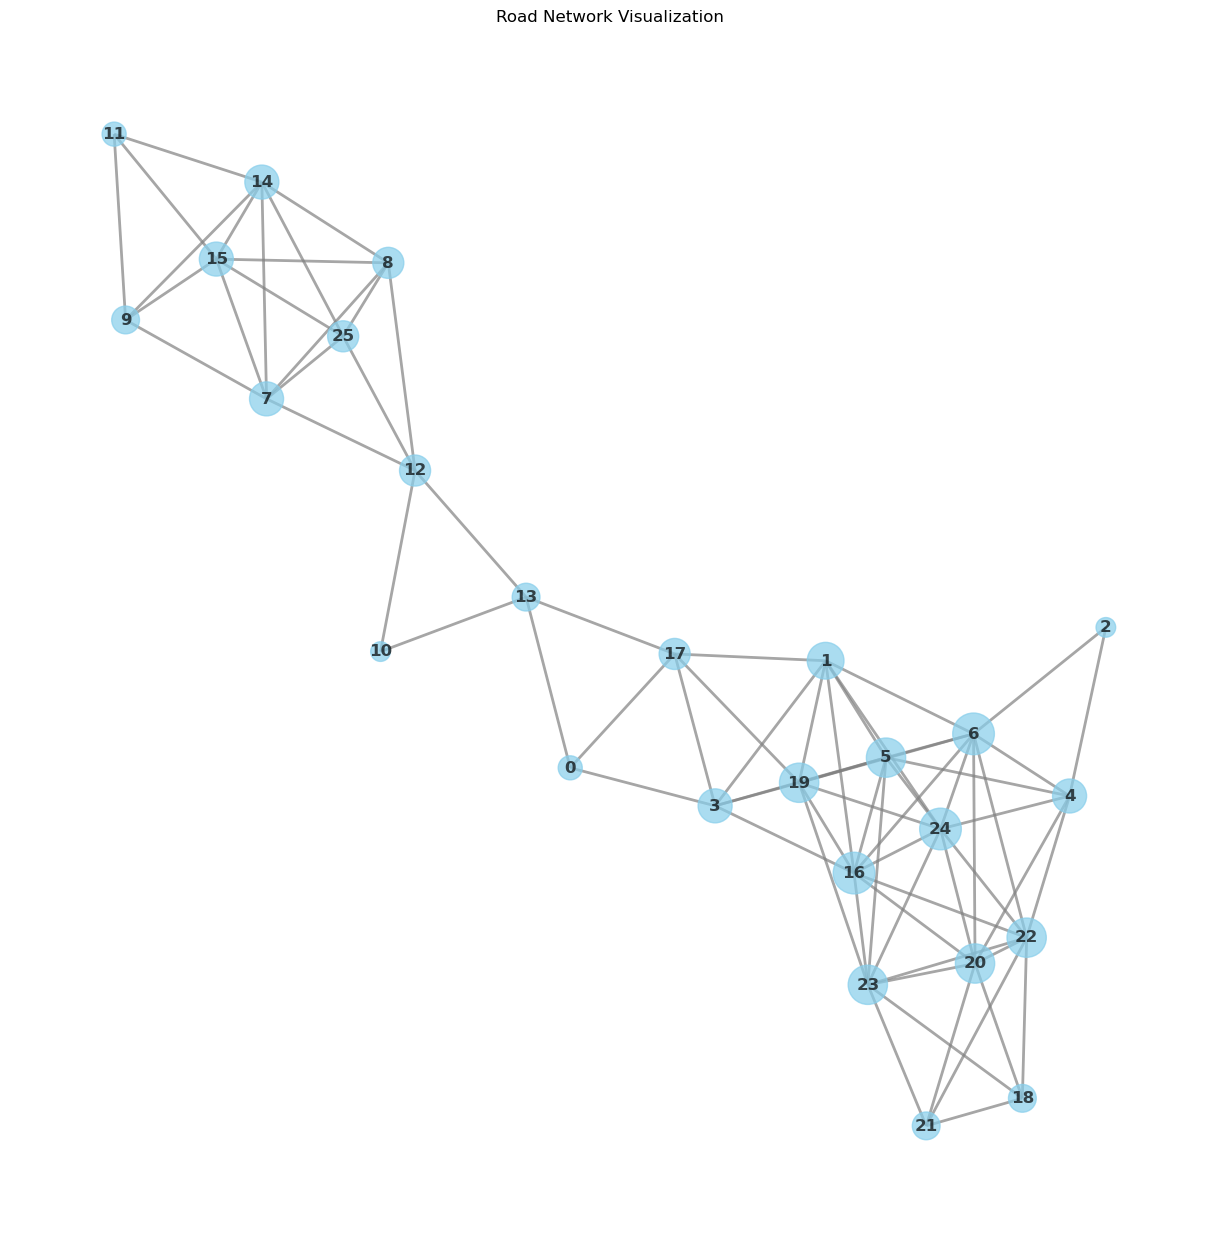

In [96]:
G = nx.from_numpy_array(adjacency_matrix)

# Choose a layout that spreads nodes apart
pos = nx.kamada_kawai_layout(G)

# Calculate node degrees and use them to determine node sizes
degrees = dict(G.degree())
node_sizes = [v * 100 for v in degrees.values()]  # Scale degree values for size

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray',
        node_size=node_sizes, alpha=0.7, font_weight='bold', width=2)

plt.title("Road Network Visualization")
plt.axis('off')  # Hide axes for cleaner visualization
plt.show()


In [97]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [98]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = ops.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = ops.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = ops.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return ops.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [99]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.7332 - val_loss: 0.3222
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.2628 - val_loss: 0.1834
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1572 - val_loss: 0.1336
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.1250 - val_loss: 0.1087
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.1049 - val_loss: 0.0936
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0924 - val_loss: 0.0848
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0853 - val_loss: 0.0800
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0817 - val_loss: 0.0777
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0797 - val_loss: 0.0764
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0784 - val_loss: 0.0754
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0774 - val_loss: 0.0748
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0

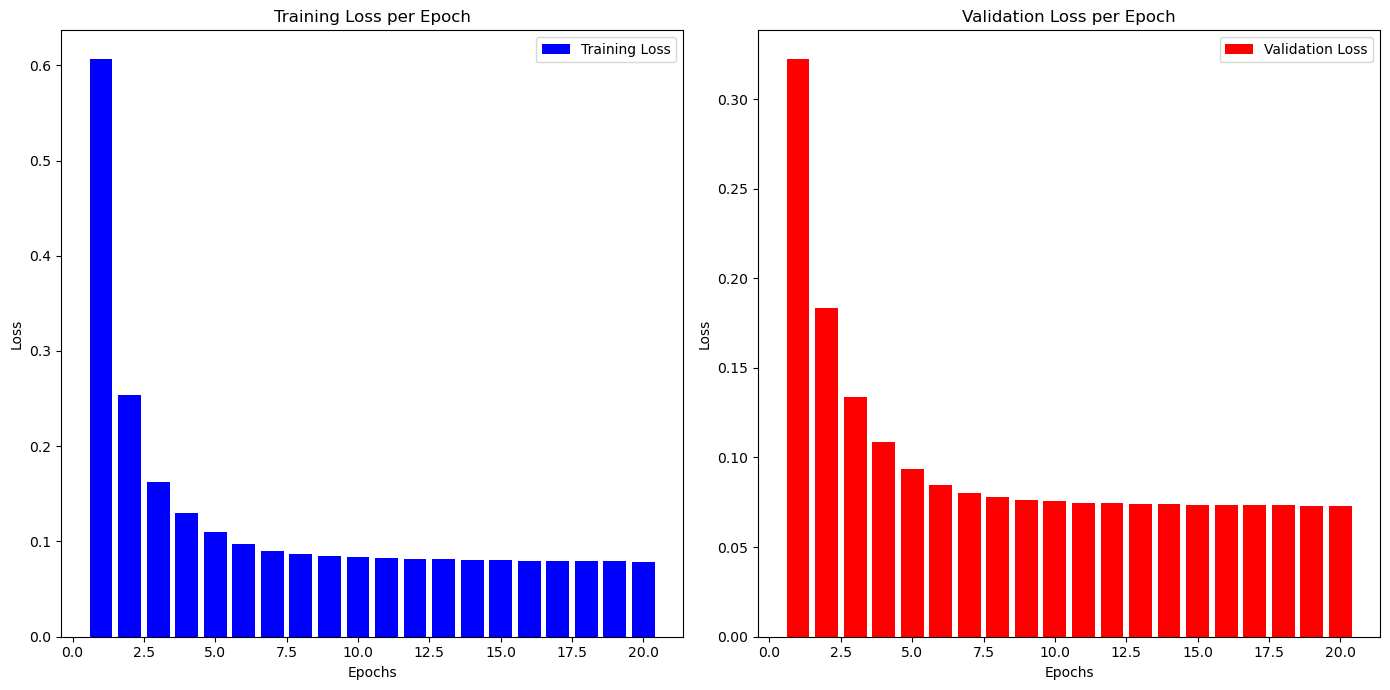

In [100]:
epochs = range(1, 21)
plt.figure(figsize=(14, 7))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.bar(epochs, train_loss, color='blue', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.bar(epochs, val_loss, color='red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [101]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


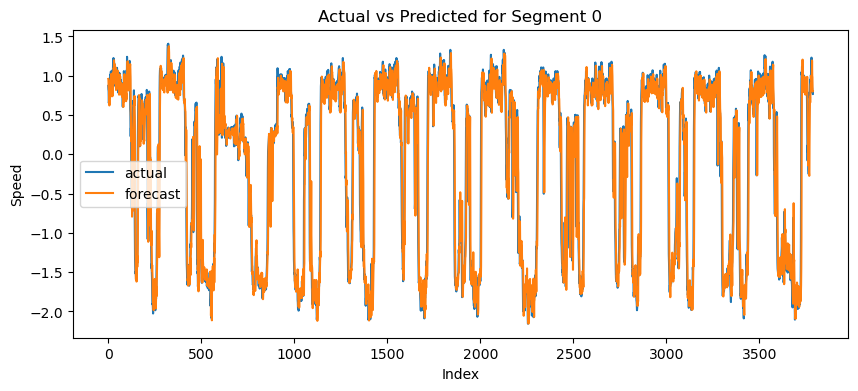

Segment 0 - Naive MAE: 0.2322, Model MAE: 0.2273


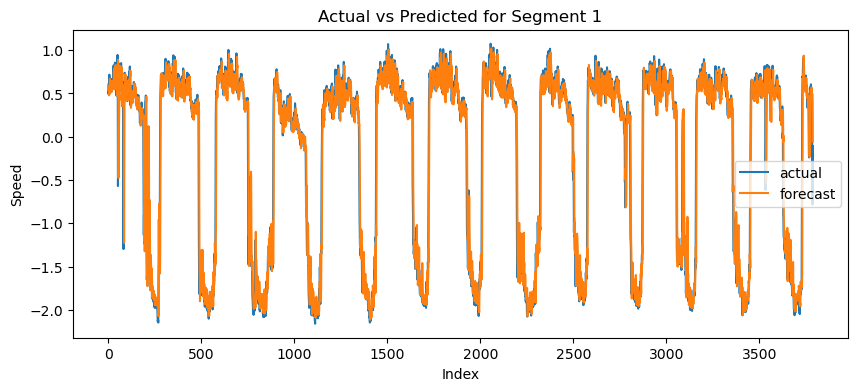

Segment 1 - Naive MAE: 0.1554, Model MAE: 0.1534


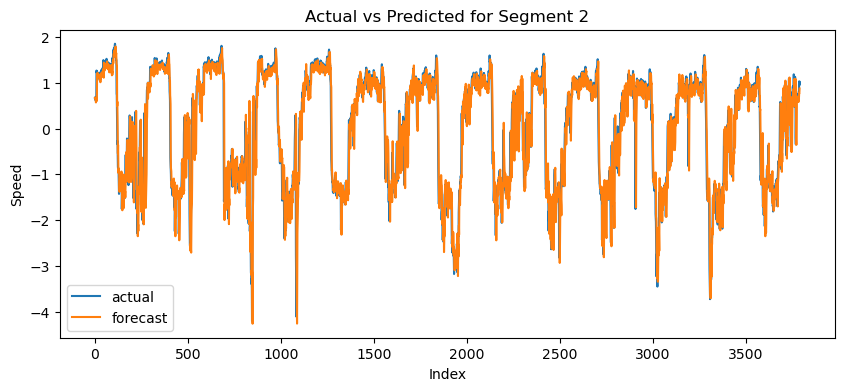

Segment 2 - Naive MAE: 0.2822, Model MAE: 0.2836


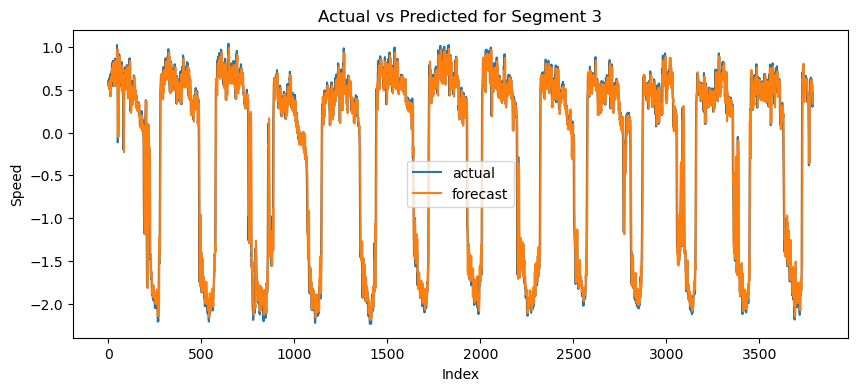

Segment 3 - Naive MAE: 0.1676, Model MAE: 0.1648


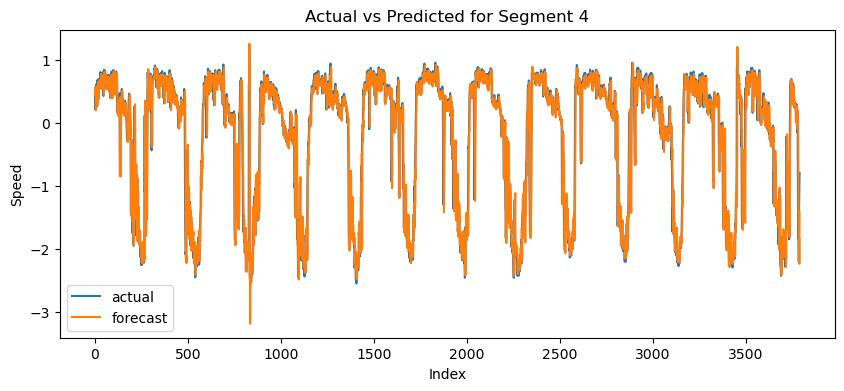

Segment 4 - Naive MAE: 0.2219, Model MAE: 0.2205


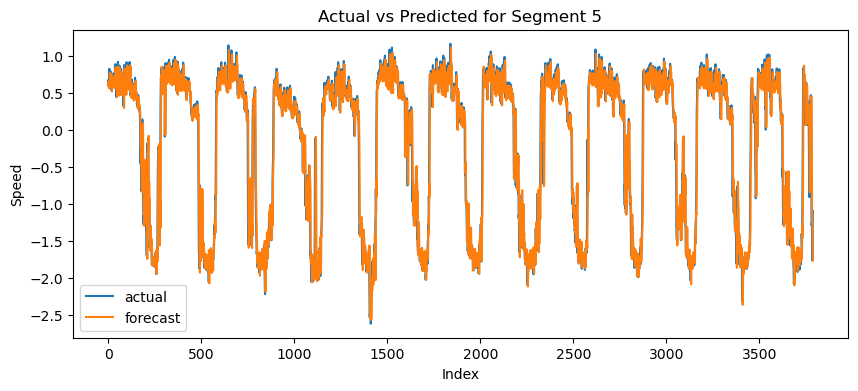

Segment 5 - Naive MAE: 0.1816, Model MAE: 0.1777


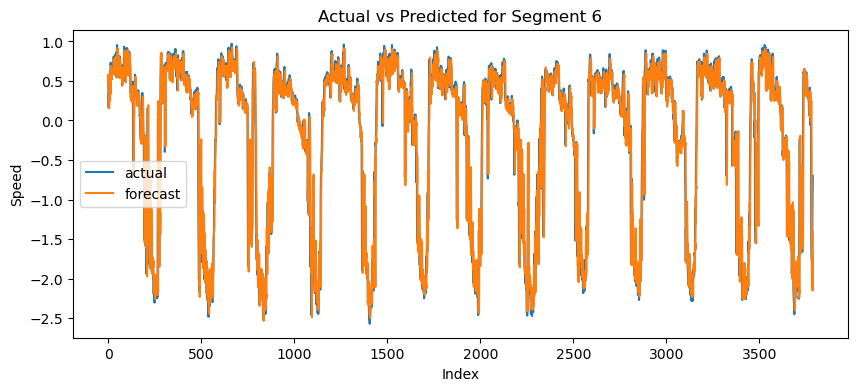

Segment 6 - Naive MAE: 0.2083, Model MAE: 0.2062


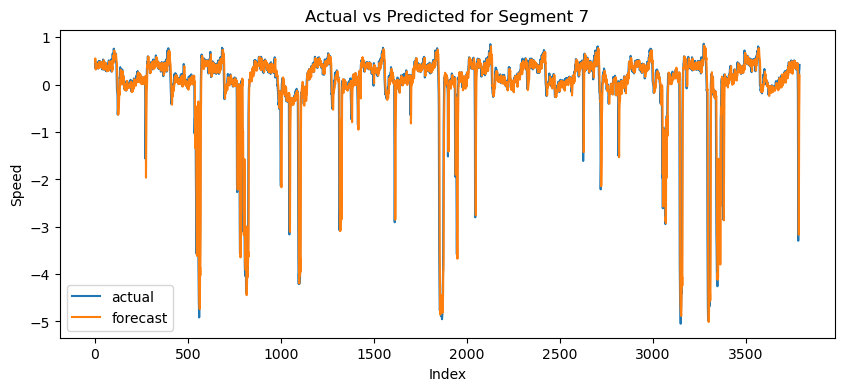

Segment 7 - Naive MAE: 0.2023, Model MAE: 0.1966


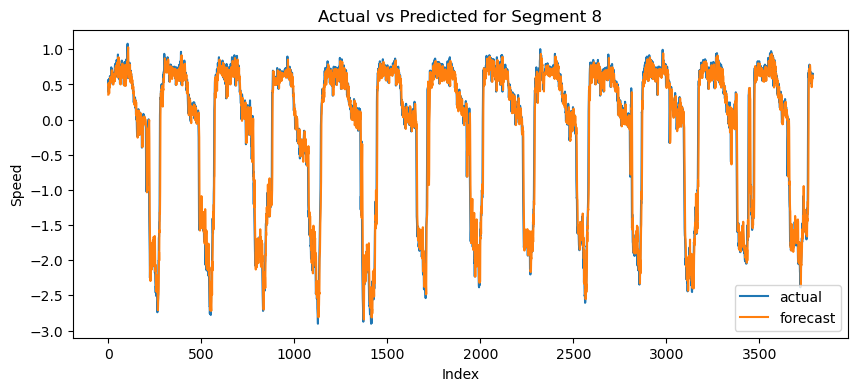

Segment 8 - Naive MAE: 0.1585, Model MAE: 0.1531


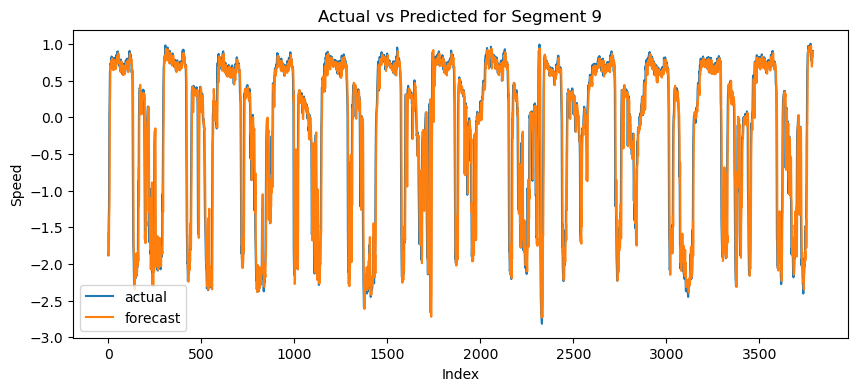

Segment 9 - Naive MAE: 0.2302, Model MAE: 0.2207


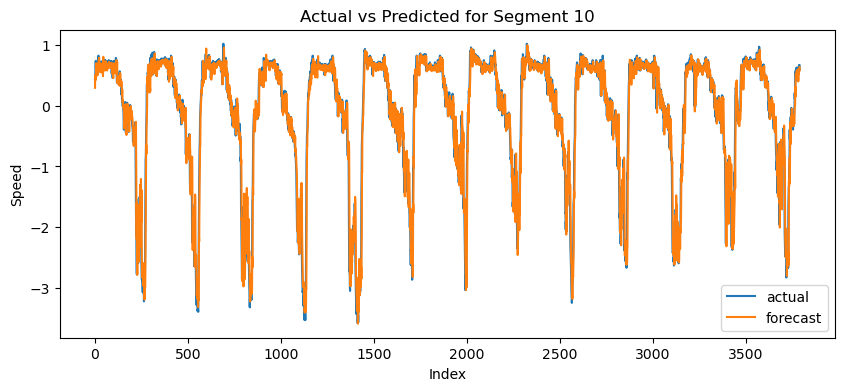

Segment 10 - Naive MAE: 0.1763, Model MAE: 0.1703


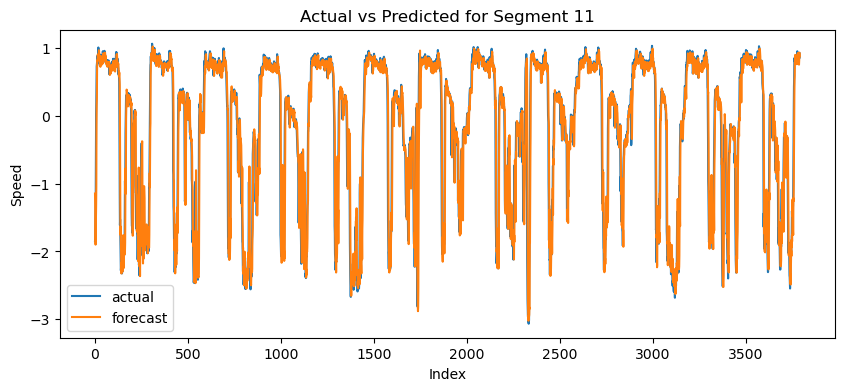

Segment 11 - Naive MAE: 0.2313, Model MAE: 0.2208


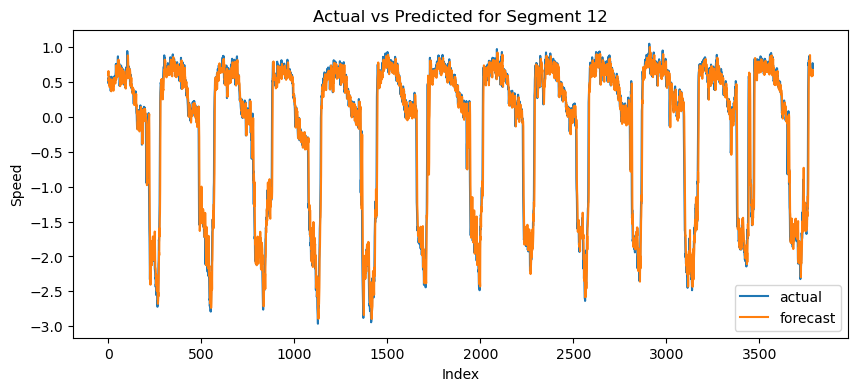

Segment 12 - Naive MAE: 0.1535, Model MAE: 0.1482


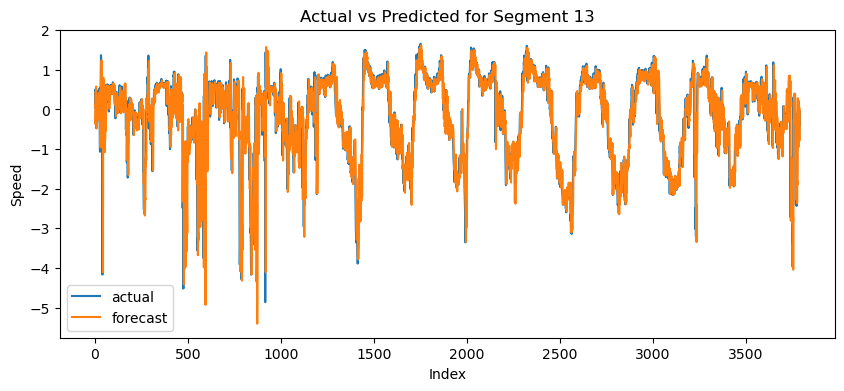

Segment 13 - Naive MAE: 0.3421, Model MAE: 0.3386


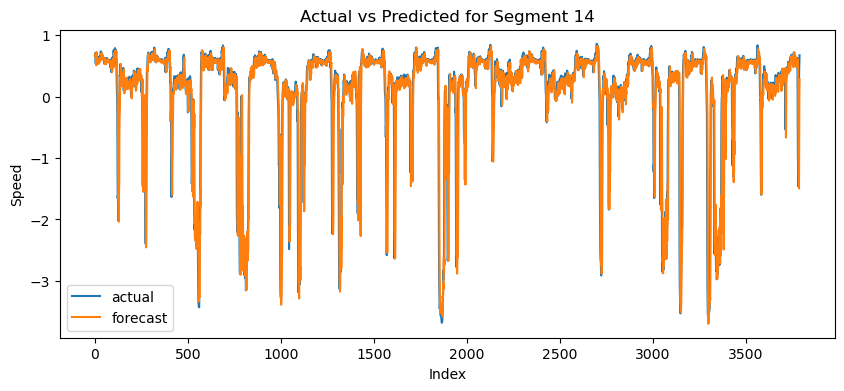

Segment 14 - Naive MAE: 0.2110, Model MAE: 0.2071


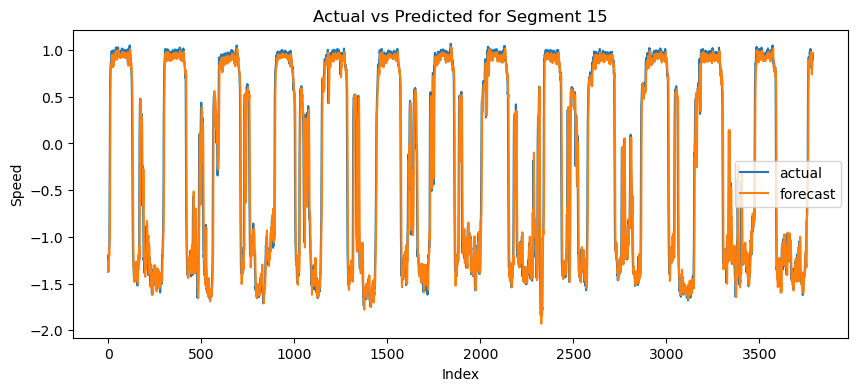

Segment 15 - Naive MAE: 0.1655, Model MAE: 0.1640


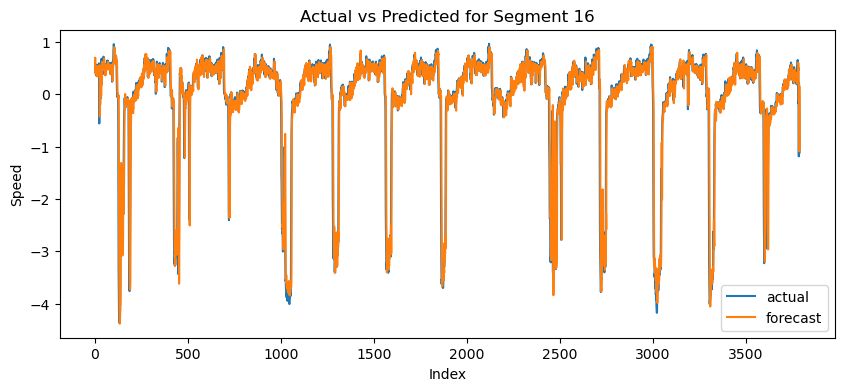

Segment 16 - Naive MAE: 0.1952, Model MAE: 0.1940


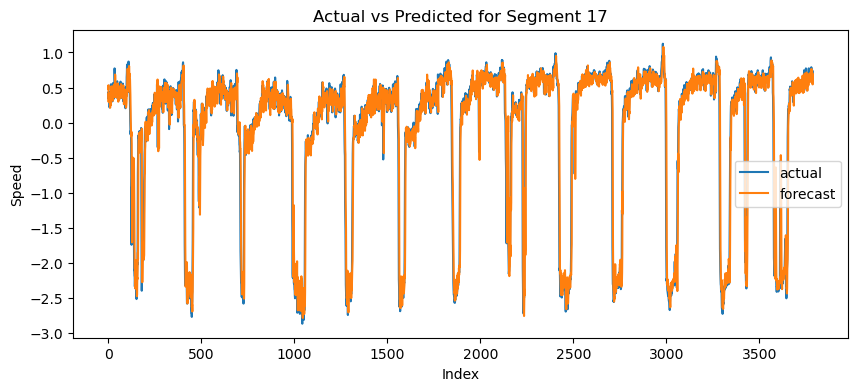

Segment 17 - Naive MAE: 0.1694, Model MAE: 0.1679


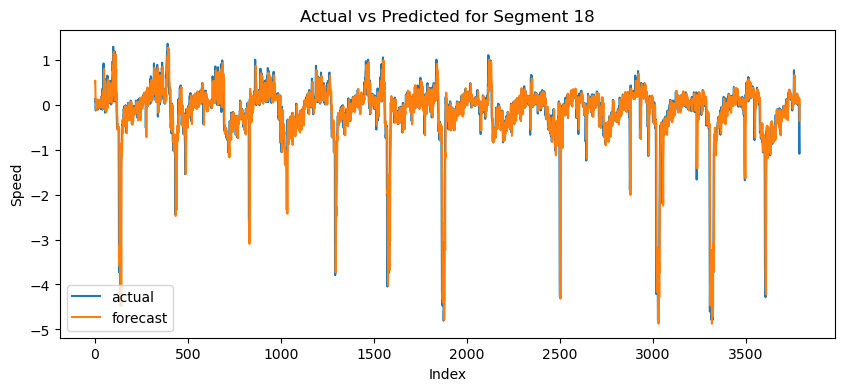

Segment 18 - Naive MAE: 0.2357, Model MAE: 0.2313


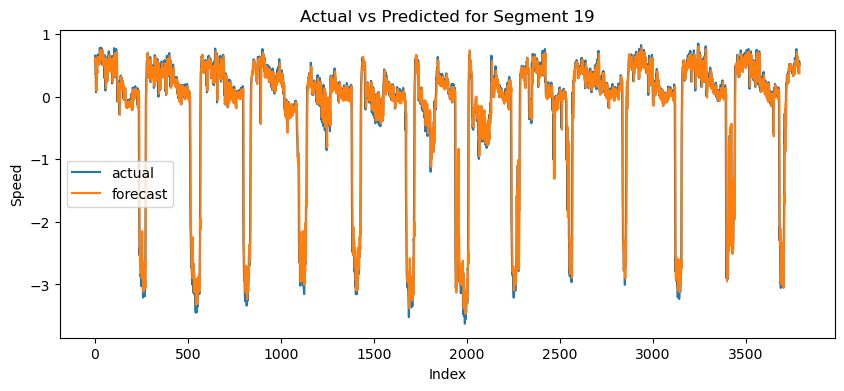

Segment 19 - Naive MAE: 0.1887, Model MAE: 0.1833


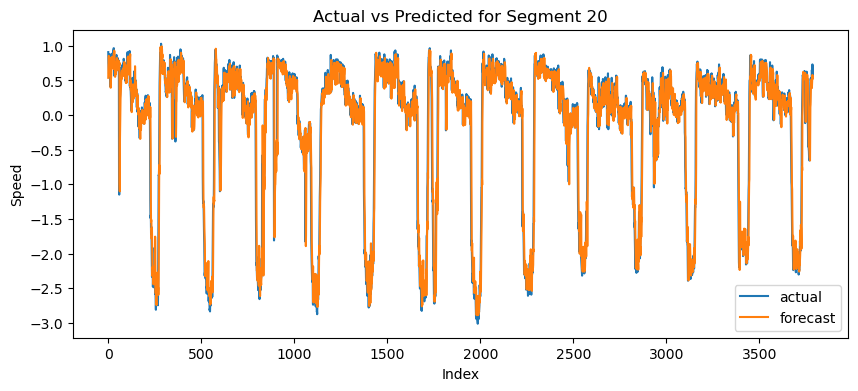

Segment 20 - Naive MAE: 0.1907, Model MAE: 0.1851


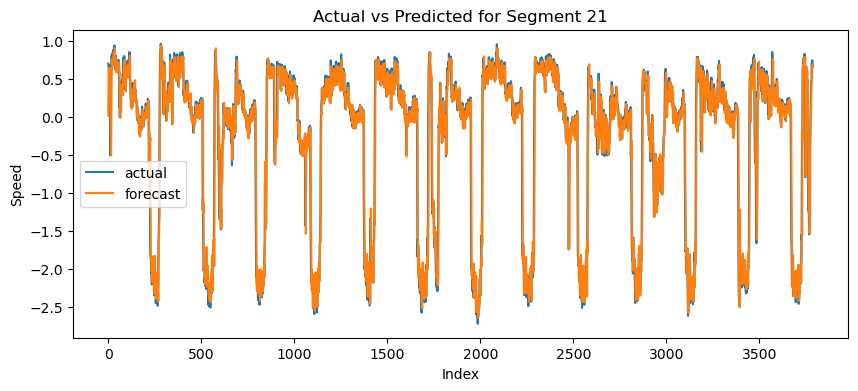

Segment 21 - Naive MAE: 0.1835, Model MAE: 0.1811


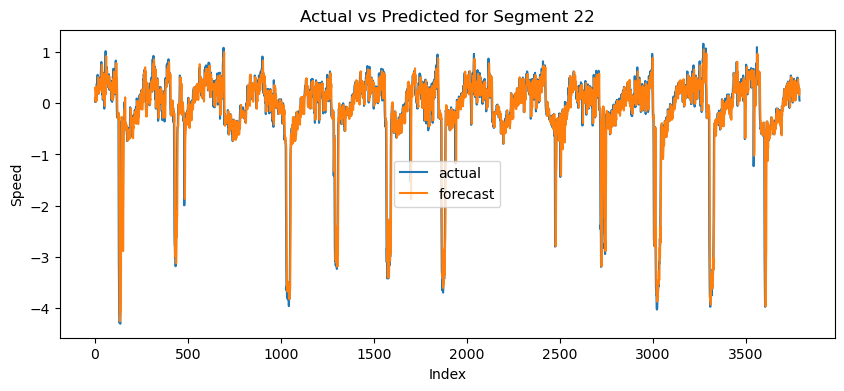

Segment 22 - Naive MAE: 0.2193, Model MAE: 0.2141


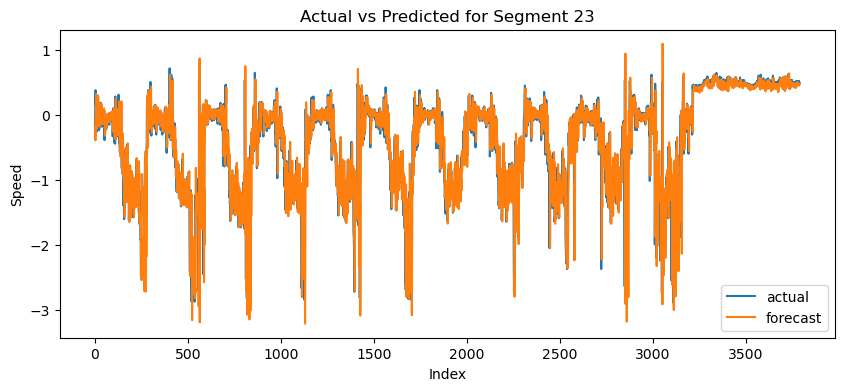

Segment 23 - Naive MAE: 0.2495, Model MAE: 0.2508


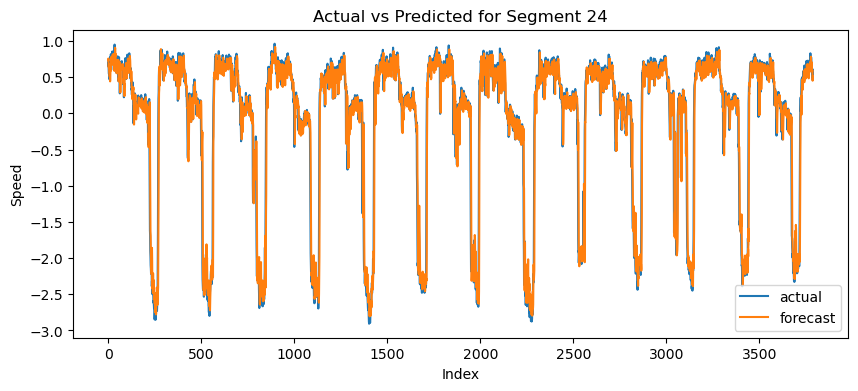

Segment 24 - Naive MAE: 0.1714, Model MAE: 0.1677


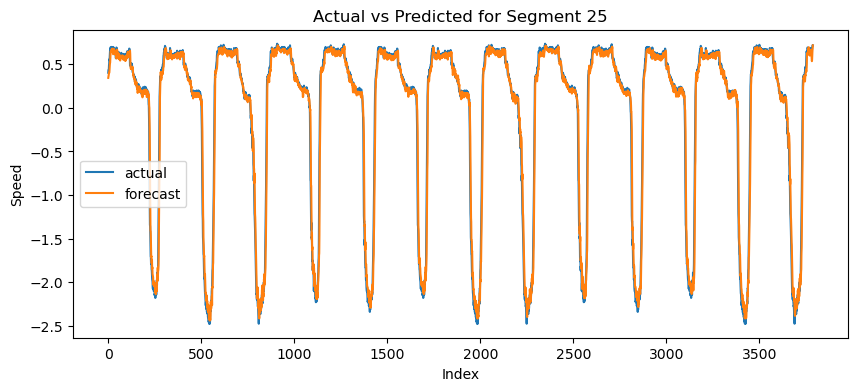

Segment 25 - Naive MAE: 0.0755, Model MAE: 0.0744


In [102]:
glstm_mae_scores = {}
for i in range(26):
    plt.figure(figsize=(10, 4))
    plt.plot(y[:, 0, i])
    plt.plot(y_pred[:, 0, i])
    plt.title(f'Actual vs Predicted for Segment {i}')
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.legend(["actual", "forecast"])
    plt.show()

    naive_mae = np.abs(x_test[:, -1, i, 0] - y[:, 0, i]).mean()
    model_mae = np.abs(y_pred[:, 0, i] - y[:, 0, i]).mean()
    glstm_mae_scores[f'segment_{i}'] = model_mae
    
    print(f"Segment {i} - Naive MAE: {naive_mae:.4f}, Model MAE: {model_mae:.4f}")

## XGBOOST

XGBOOST is one of the many models that can be used for forecasting and it is mostly powerful when there are several features and lots of non-linearity. For simpler time-series forecasting models, using a forecaster such as Facebook Prophet could be better. However, in this example, I wanted to explore the XGBOOST and generate features from the time-series index such as the hour of the speed or day of the week etc. In summary, the following steps are taken to model and forecast the speed for the testing period:

Creating a Weekday Index:

A custom function generates a datetime index that excludes weekends. This index is used to ensure that data analyses and model training only consider weekdays, reflecting typical traffic patterns on workdays.

Preprocessing and Feature Engineering:

Data Import and Indexing: Speed data is loaded into a DataFrame with the generated weekday index.
Time Features Extraction: Time-related features such as the hour of the day and day of the week are extracted. Additional binary features identify parts of the day (morning, afternoon, evening, night).
Temporal Dynamics: Features like rolling averages and lags are computed to capture temporal trends and dependencies in the speed data.
Normalization: Features are normalized based on statistics (mean and standard deviation) calculated from the training set to prevent data leakage and help the model generalize better.

Data Splitting:

The dataset is divided into training, validation, and testing sets based on specified proportions, ensuring that the model is trained, validated, and tested on separate data segments.

Model Setup and Training:

XGBoost Configuration: A model for each road segment is set up using XGBoost with specified hyperparameters like maximum depth and learning rate.
Silent Training: Training is performed without verbose output, with early stopping implemented to prevent overfitting.
Evaluation and Prediction:
The trained model is used to make predictions on the test set.
The Mean Absolute Error (MAE) is calculated for each segment to quantify the model's accuracy, comparing the predicted speeds with actual speeds.

Visualization:

For each road segment, a plot is generated showing actual vs. predicted speeds to visually assess the model's performance.
These plots help in understanding the model's prediction capabilities and identifying any potential discrepancies or areas for improvement.

Reporting Results:

The MAE for each segment is printed, providing a clear summary of the model's performance across different segments.


In [103]:
import pandas as pd
import numpy as np

def create_weekday_index(start_date, periods, freq):
    '''
    This function is to create time-series index for the speed data from May to June 2021 weekdays at 5 minutes intervals. 
    
    '''
    dt_index = pd.date_range(start=start_date, periods=periods * 3, freq=freq)  

    weekday_index = dt_index[dt_index.dayofweek < 5]
    return weekday_index[:periods]

def preprocess_with_time_features(data_array: np.ndarray, train_size: float, val_size: float):

    num_time_steps = data_array.shape[0]
    time_index = create_weekday_index(pd.Timestamp('2012-05-01'), num_time_steps, '5T')

    df = pd.DataFrame(data_array, columns=[f'segment_{i}' for i in range(data_array.shape[1])])
    df.set_index(time_index, inplace=True)

    # extract time features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_morning'] = (df['hour'] >= 6) & (df['hour'] < 12).astype(int)
    df['is_afternoon'] = (df['hour'] >= 12) & (df['hour'] < 18).astype(int)
    df['is_evening'] = (df['hour'] >= 18) & (df['hour'] < 24).astype(int)
    df['is_night'] = (df['hour'] < 6).astype(int)
    df['time_since_start'] = (df.index - df.index[0]).total_seconds() / 3600  

    # include rolling averages and lagged features
    for i in [3, 6, 12]: 
        df[f'rolling_mean_{i}'] = df[[f'segment_{j}' for j in range(data_array.shape[1])]].mean(axis=1).rolling(window=i).mean()
        df[f'lag_{i}'] = df[[f'segment_{j}' for j in range(data_array.shape[1])]].mean(axis=1).shift(i)

    # select features and normalize same as the GNN/LSTM approach
    features = df.drop(columns=[f'segment_{i}' for i in range(data_array.shape[1])])
    targets = df[[f'segment_{i}' for i in range(data_array.shape[1])]]

    train_cutoff = int(num_time_steps * train_size)
    val_cutoff = int(num_time_steps * (train_size + val_size))
    
    mean = features.iloc[:train_cutoff].mean()
    std = features.iloc[:train_cutoff].std()

    features = (features - mean) / std

    # split data into train, validation, test with 50% training, 20% validation and 30% testing same as the GNN/LSTM approach
    train_features, train_targets = features.iloc[:train_cutoff], targets.iloc[:train_cutoff]
    val_features, val_targets = features.iloc[train_cutoff:val_cutoff], targets.iloc[train_cutoff:val_cutoff]
    test_features, test_targets = features.iloc[val_cutoff:], targets.iloc[val_cutoff:]

    return (train_features, train_targets), (val_features, val_targets), (test_features, test_targets)

(train_features, train_targets), (val_features, val_targets), (test_features, test_targets) = preprocess_with_time_features(speeds_array, train_size=0.5, val_size=0.2)


/var/folders/p4/f02y3z810l530mmz7x833j3w0000gn/T/ipykernel_82963/2989683755.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dt_index = pd.date_range(start=start_date, periods=periods * 3, freq=freq)


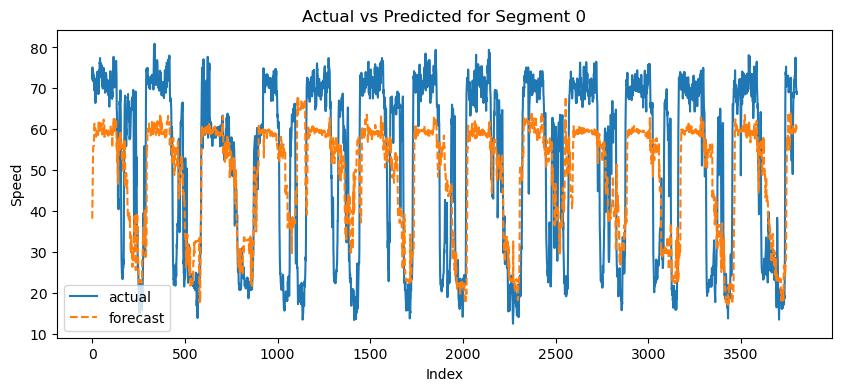

MAE for Segment 0: 13.37


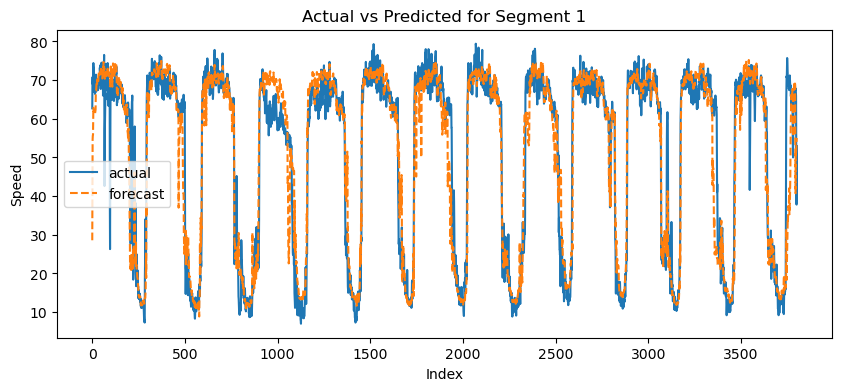

MAE for Segment 1: 4.61


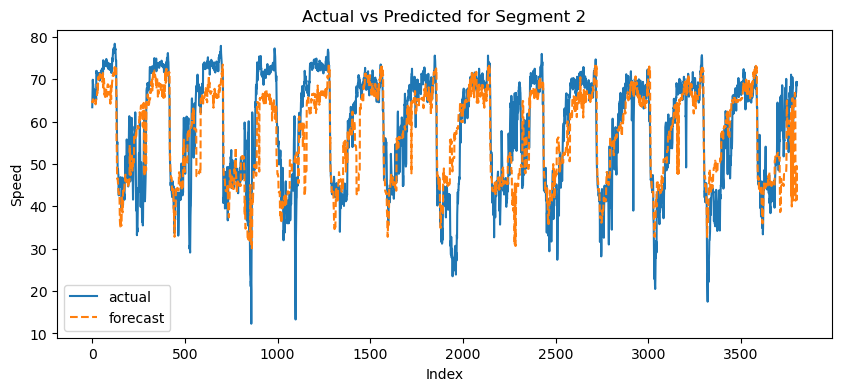

MAE for Segment 2: 5.65


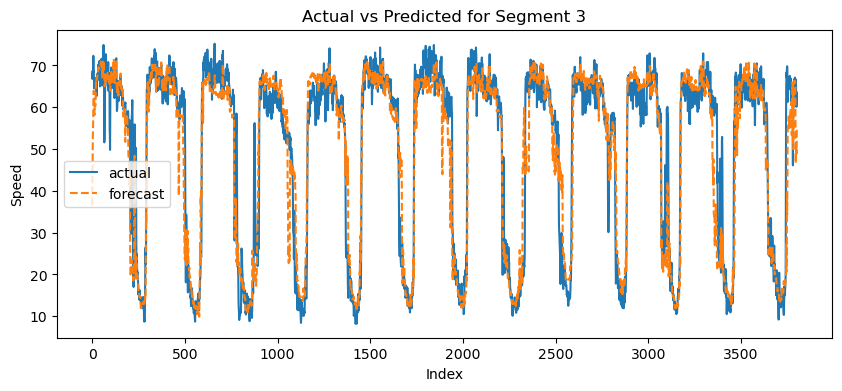

MAE for Segment 3: 4.58


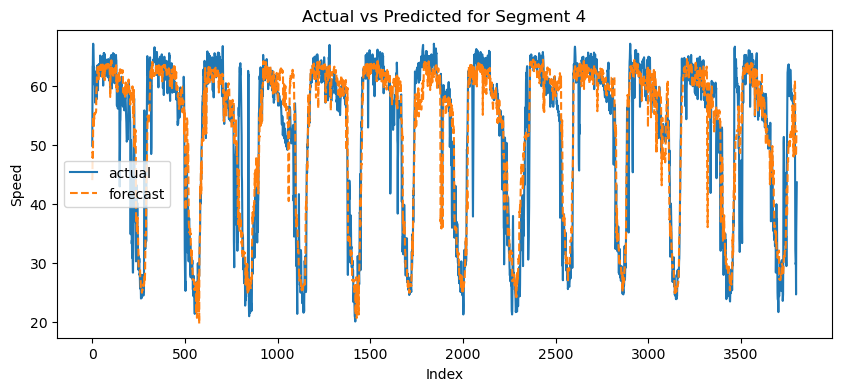

MAE for Segment 4: 3.68


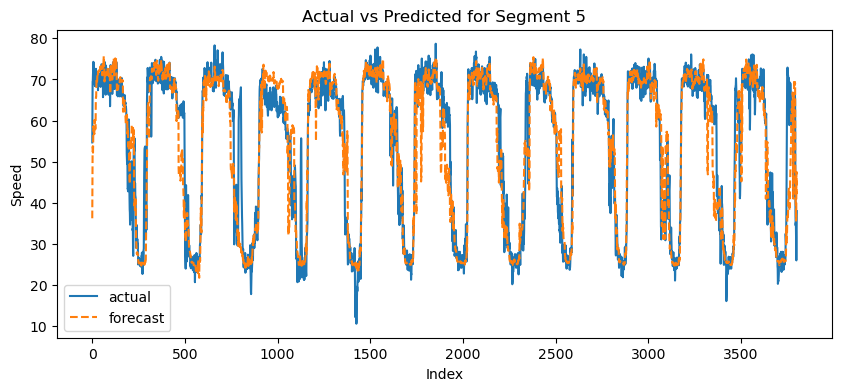

MAE for Segment 5: 4.24


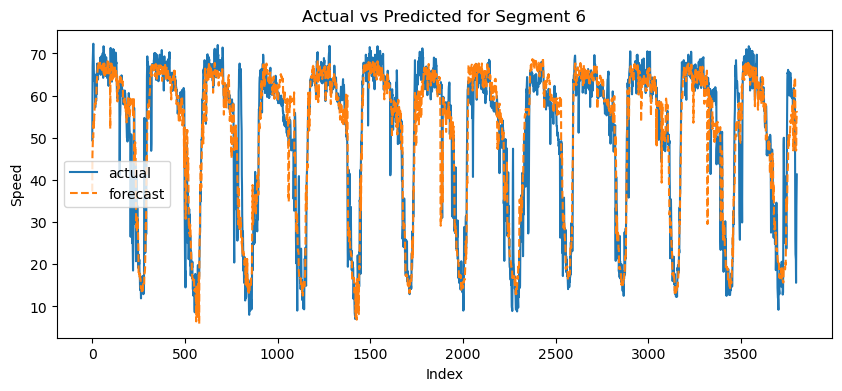

MAE for Segment 6: 4.42


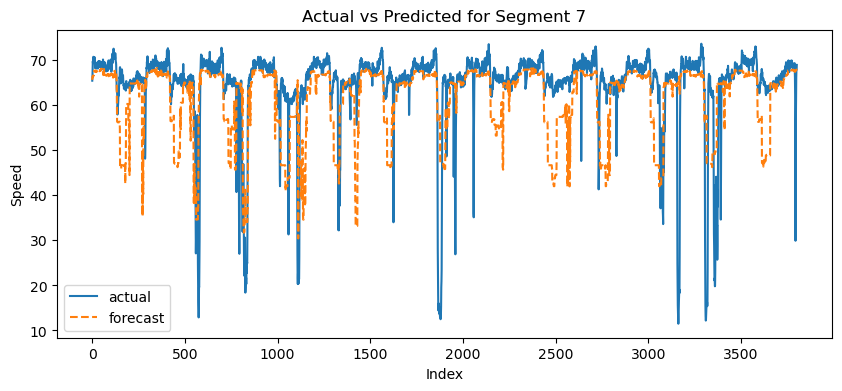

MAE for Segment 7: 5.99


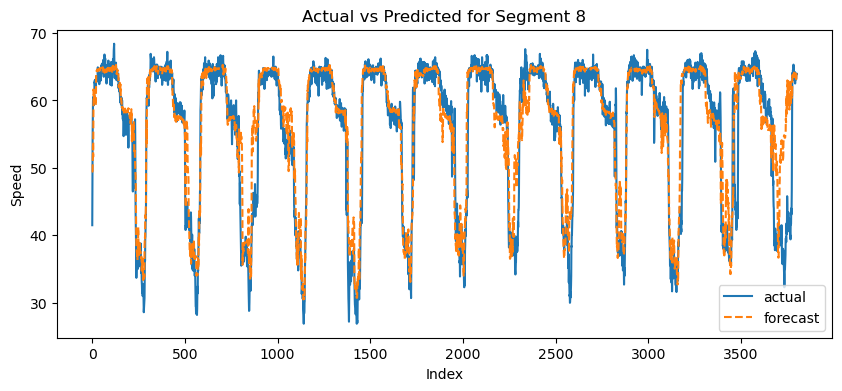

MAE for Segment 8: 2.66


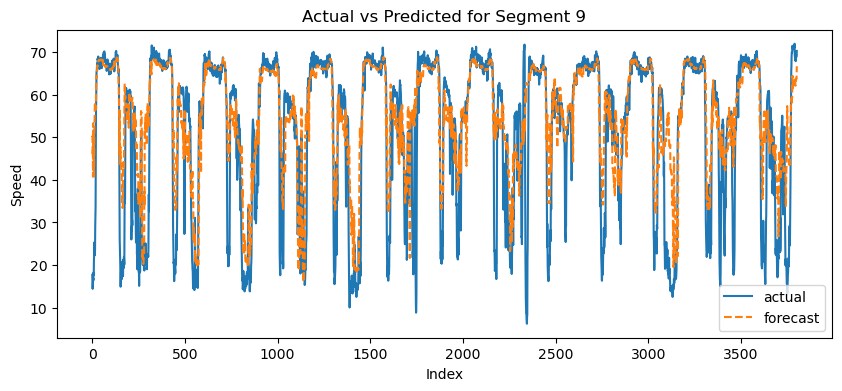

MAE for Segment 9: 7.08


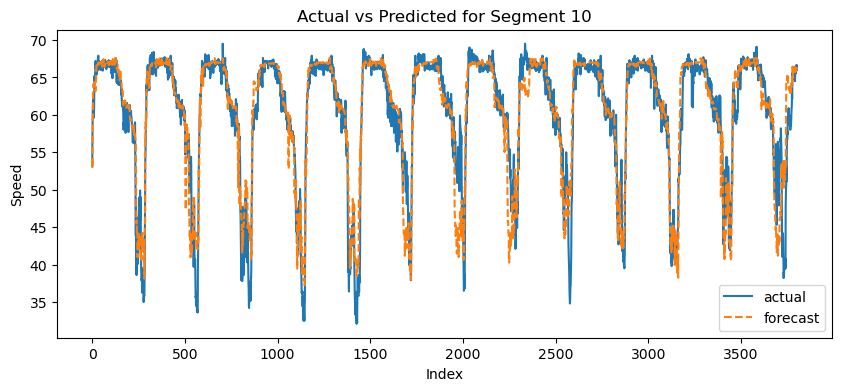

MAE for Segment 10: 1.98


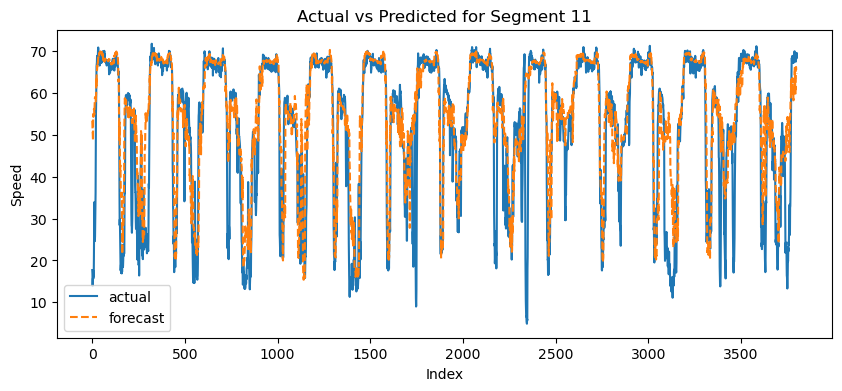

MAE for Segment 11: 5.90


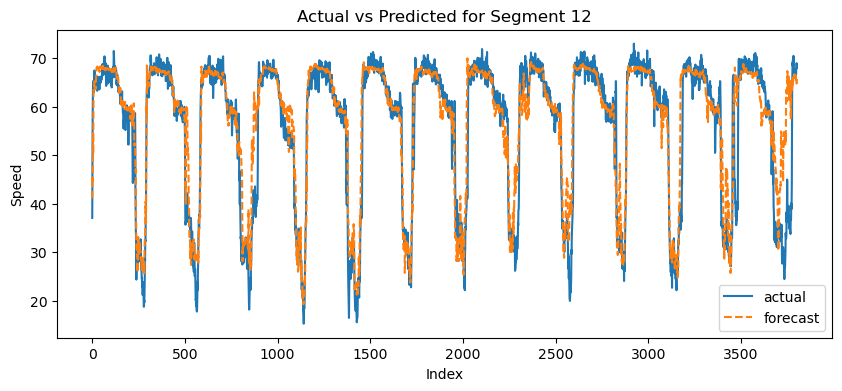

MAE for Segment 12: 3.56


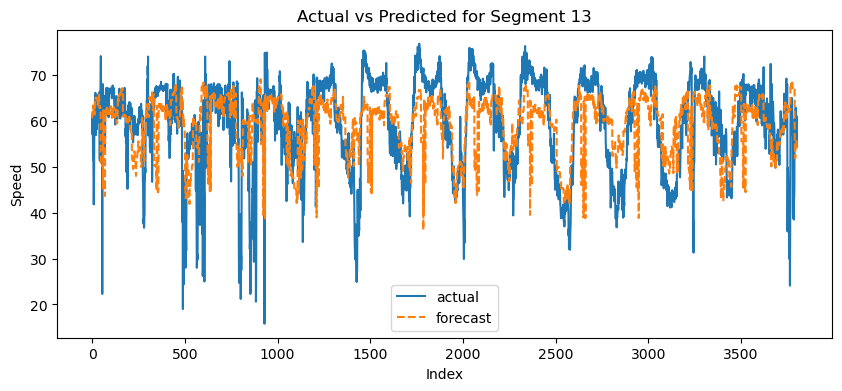

MAE for Segment 13: 6.81


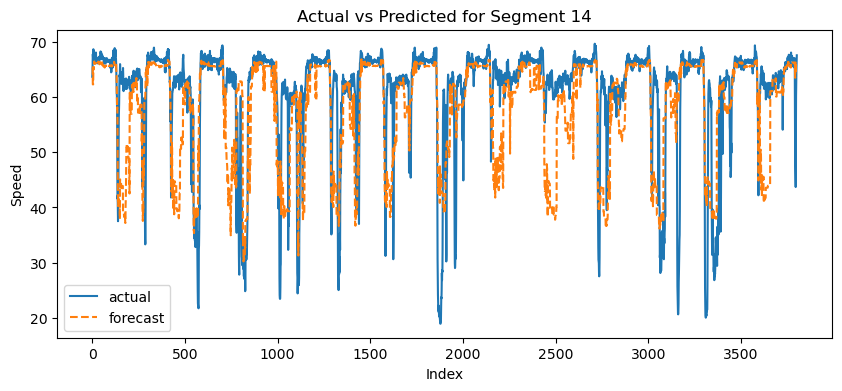

MAE for Segment 14: 6.07


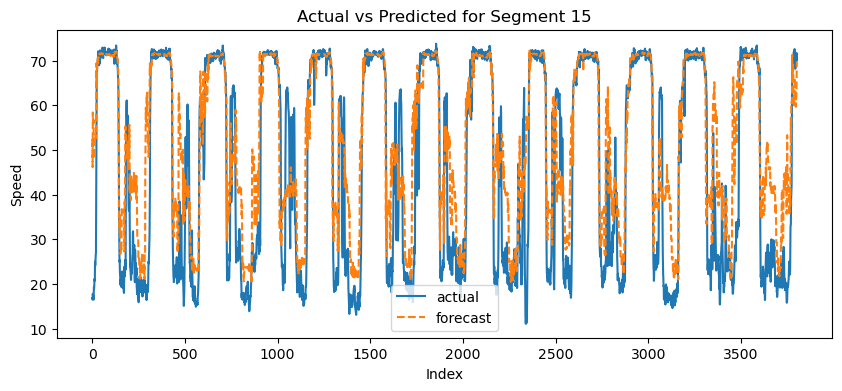

MAE for Segment 15: 8.48


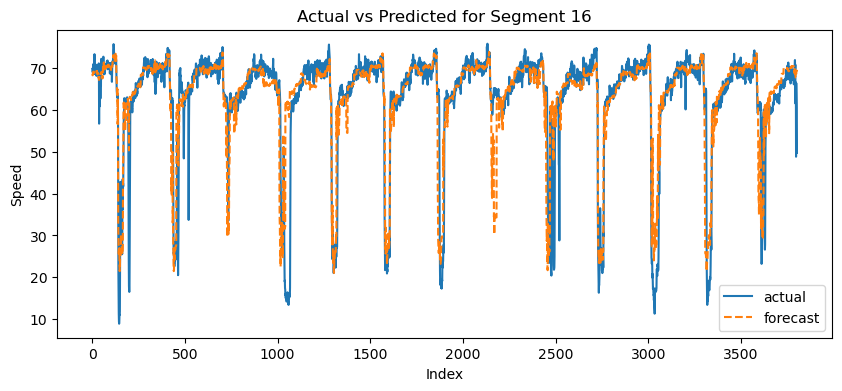

MAE for Segment 16: 3.62


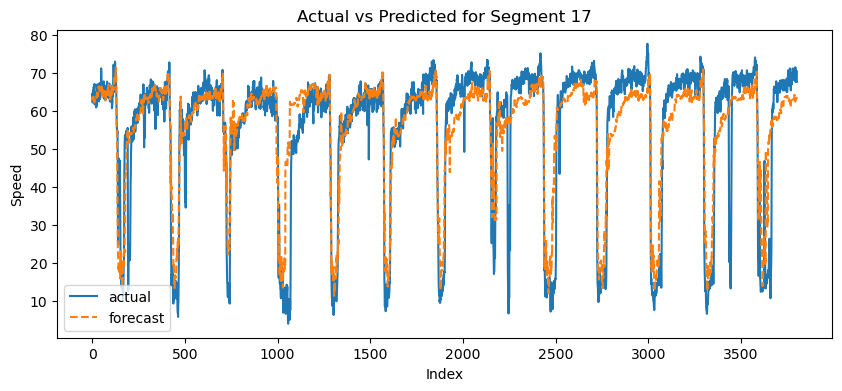

MAE for Segment 17: 5.82


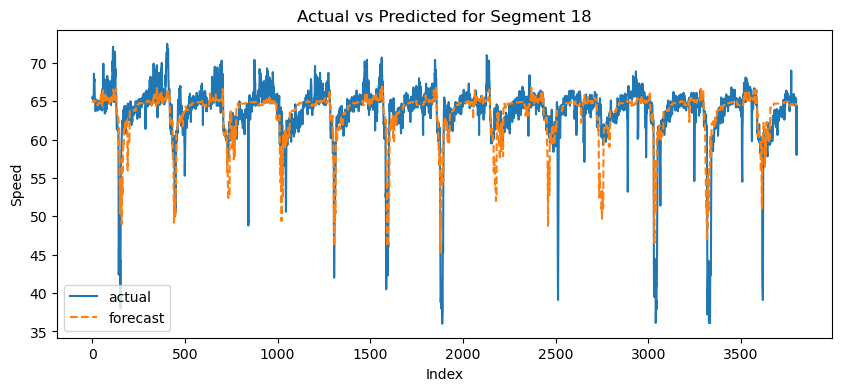

MAE for Segment 18: 1.75


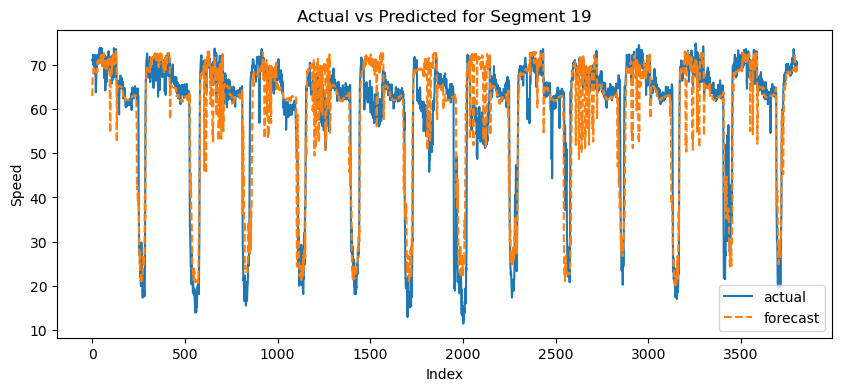

MAE for Segment 19: 4.59


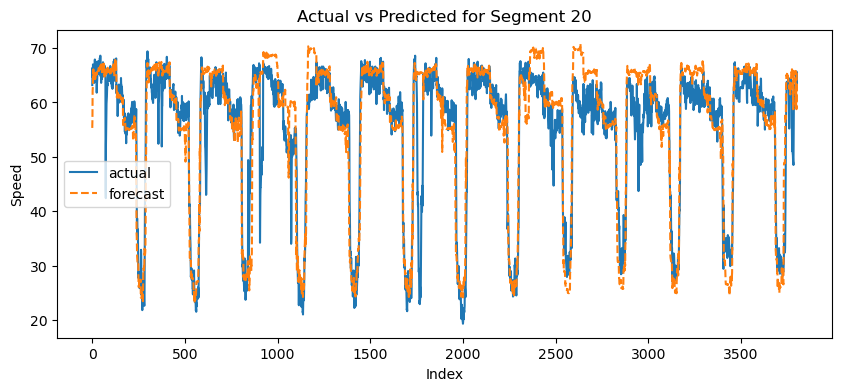

MAE for Segment 20: 3.87


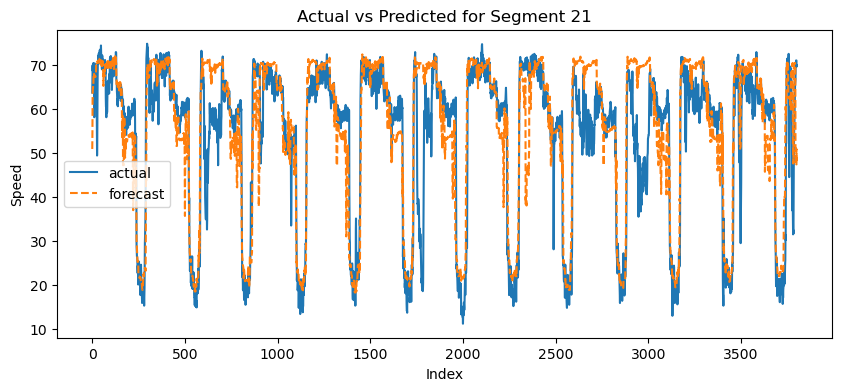

MAE for Segment 21: 6.18


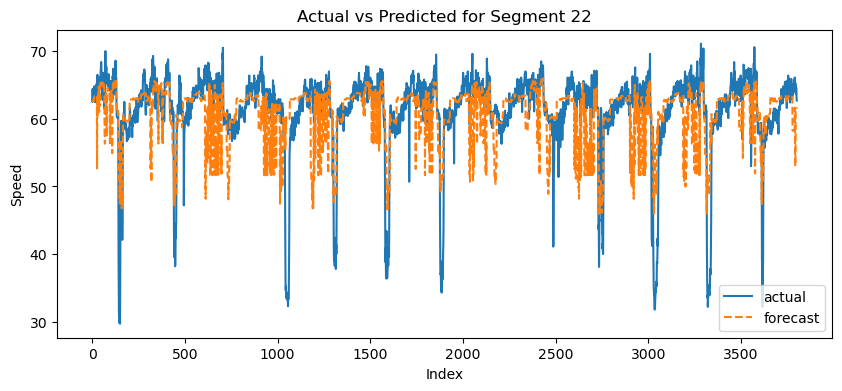

MAE for Segment 22: 3.61


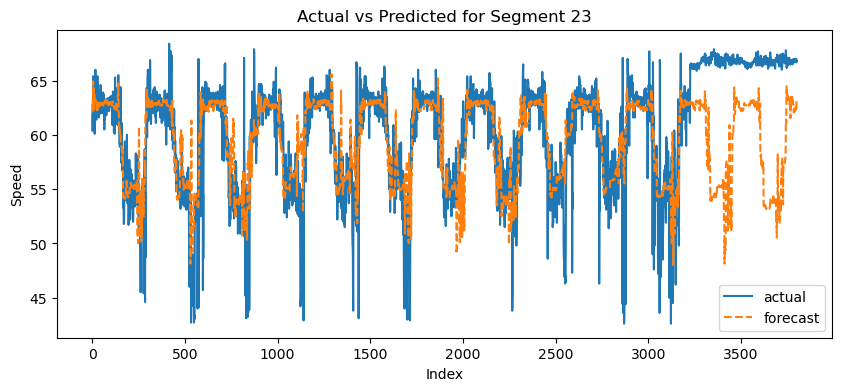

MAE for Segment 23: 2.86


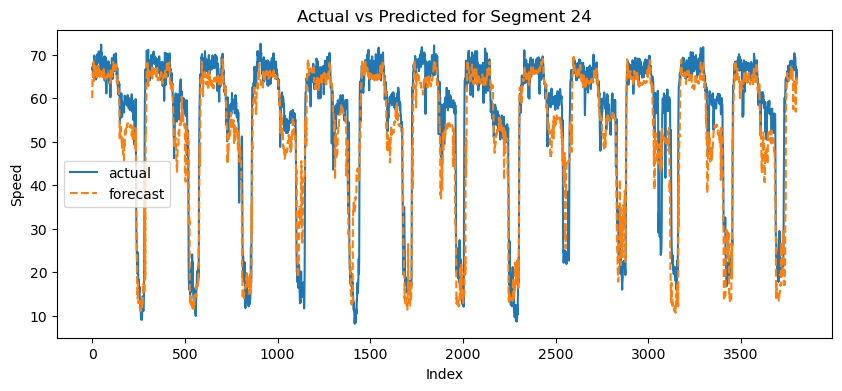

MAE for Segment 24: 5.13


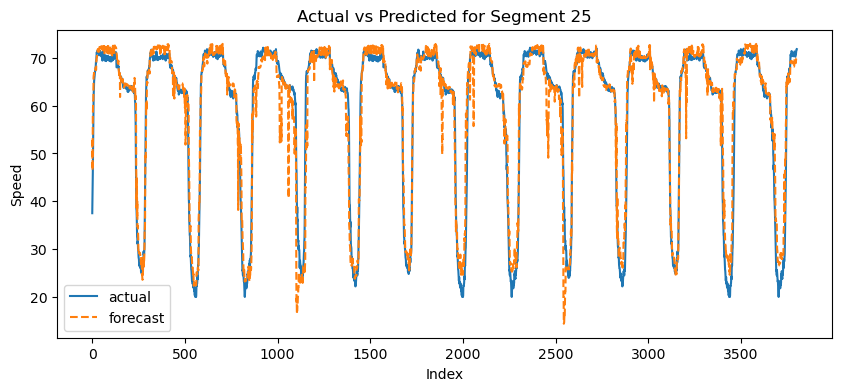

MAE for Segment 25: 2.29


In [116]:
import logging
logging.getLogger('xgboost').setLevel(logging.ERROR)

xgb_mae_scores = {}
num_segments = 26  

for segment_index in range(num_segments):
    dtrain = xgb.DMatrix(train_features, label=train_targets.iloc[:, segment_index])
    dval = xgb.DMatrix(val_features, label=val_targets.iloc[:, segment_index])
    dtest = xgb.DMatrix(test_features, label=test_targets.iloc[:, segment_index])

    # XGBoost parameters that were not tuned.
    params = {
        'max_depth': 8,
        'eta': 0.1,
        'objective': 'reg:squarederror',
        'eval_metric': 'mae'
    }

    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], verbose_eval=False, early_stopping_rounds=10)

    y_pred = model.predict(dtest)
    mae = mean_absolute_error(test_targets.iloc[:, segment_index], y_pred)
    xgb_mae_scores[f'segment_{segment_index}'] = mae

    plt.figure(figsize=(10, 4))
    plt.plot(range(len(test_targets)), test_targets.iloc[:, segment_index], label='actual')
    plt.plot(range(len(test_targets)), y_pred, label='forecast', linestyle='--')
    plt.title(f'Actual vs Predicted for Segment {segment_index}')
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.legend()
    plt.show()

    print(f'MAE for Segment {segment_index}: {mae:.2f}')


# Comparing the MAE from the XGBOOST and GNN/LSTM models

As it was expected, the GNN/LSTM significantly outperfromed the XGBOOST model by accounting for the present noise in the data. However, XGBOOST was also able to pick up the time-series components given its less complexity to an acceptable level for the speed data. 

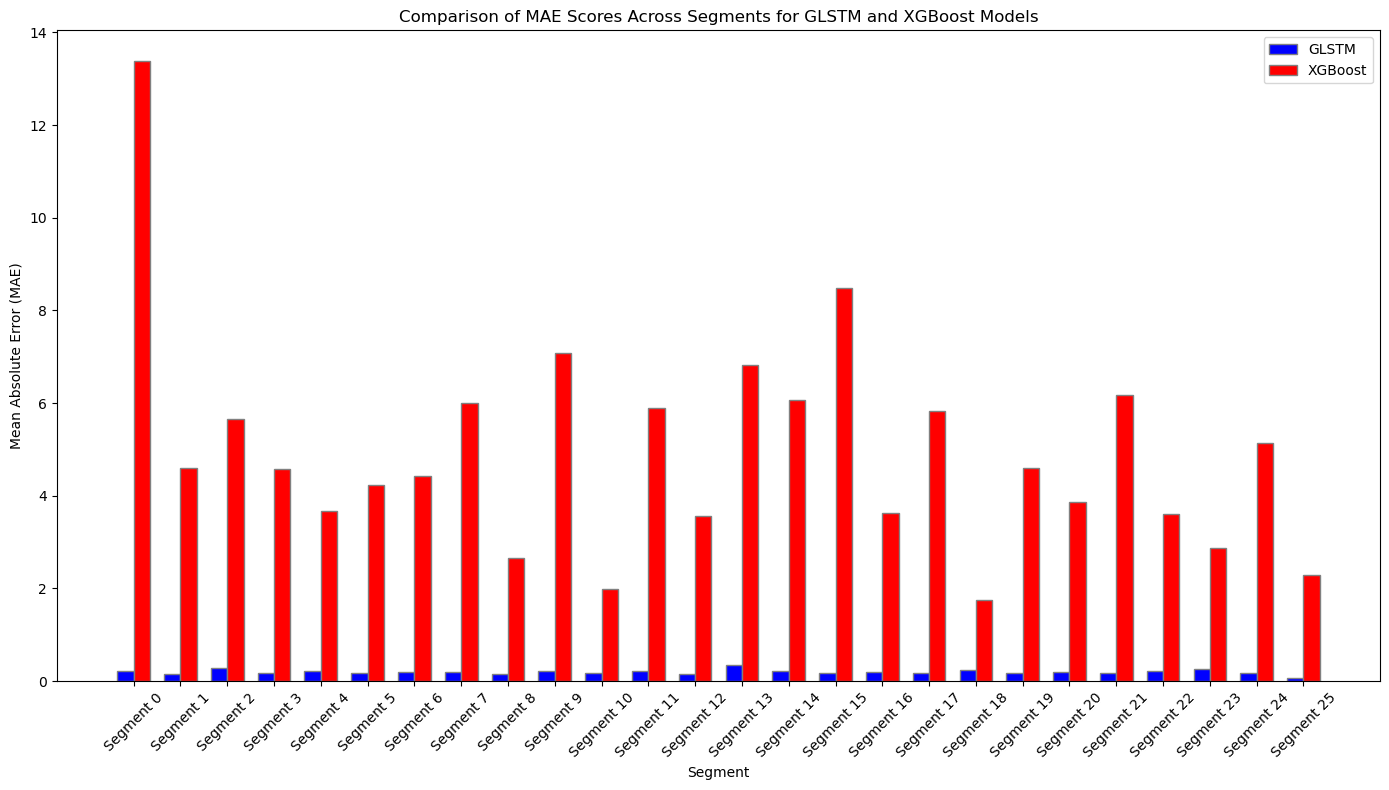

In [115]:
import numpy as np
import matplotlib.pyplot as plt

segments = range(26) 
glstm_maes = [glstm_mae_scores[f'segment_{i}'] for i in segments]
xgb_maes = [xgb_mae_scores[f'segment_{i}'] for i in segments]

plt.figure(figsize=(14, 8))
bar_width = 0.35 
positions = np.arange(len(glstm_maes))

plt.bar(positions, glstm_maes, color='b', width=bar_width, edgecolor='grey', label='GLSTM')
plt.bar(positions + bar_width, xgb_maes, color='r', width=bar_width, edgecolor='grey', label='XGBoost')

plt.xlabel('Segment')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(positions + bar_width / 2, [f'Segment {i}' for i in segments], rotation=45)
plt.legend()
plt.title('Comparison of MAE Scores Across Segments for GLSTM and XGBoost Models')
plt.tight_layout()
plt.show()
